#  Paso 1: Montar Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#  Paso 2: Instalar librerías necesarias

In [2]:
!pip install tensorflow matplotlib opencv-python --quiet

#  Paso 3: Cargar imágenes RGB y máscaras

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Directorios de imágenes RGB y máscaras de color
rgb_dir = "/content/drive/MyDrive/fugitive_emissions/Imagenes_RGB"
mask_dir = "/content/drive/MyDrive/fugitive_emissions/Mascaras_color"

def cargar_datos(rgb_dir, mask_dir, size=(256, 256), tolerance=70):
    X, Y = [], []
    emision_color = np.array([6, 5, 120])  # Color azul oscuro de emisión fugitiva (ajusta si es necesario)

    for fname in sorted(os.listdir(rgb_dir)):
        rgb_path = os.path.join(rgb_dir, fname)
        mask_path = os.path.join(mask_dir, fname)
        if os.path.exists(mask_path):
            img = cv2.imread(rgb_path)
            img = cv2.resize(img, size)

            mask = cv2.imread(mask_path)
            mask = cv2.resize(mask, size)
            mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

            # Calcula distancia al color de emisión fugitiva
            dist = np.linalg.norm(mask_rgb - emision_color, axis=-1)
            bin_mask = (dist < tolerance).astype(np.uint8)

            X.append(img / 255.0)
            Y.append(np.expand_dims(bin_mask, axis=-1))

    return np.array(X), np.array(Y)

X, Y = cargar_datos(rgb_dir, mask_dir)
print(f'Imágenes cargadas: {X.shape}, Máscaras: {Y.shape}')

Imágenes cargadas: (42, 256, 256, 3), Máscaras: (42, 256, 256, 1)


#  Paso 4: Definir modelo U-Net en Keras

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        return x

    def encoder_block(x, filters):
        f = conv_block(x, filters)
        p = layers.MaxPooling2D()(f)
        return f, p

    def decoder_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
        x = layers.concatenate([x, skip])
        x = conv_block(x, filters)
        return x

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d4)

    return Model(inputs, outputs)

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

#  Paso 5: Entrenar el modelo

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                    epochs=20, batch_size=4)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 291s 31s/step - accuracy: 0.7045 - loss: 0.3751 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 267s 30s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 341s 32s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 267s 29s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 340s 32s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 305s 30s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 324s 30s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 267s 30s/step - accuracy: 1.00

#  Paso 6: Evaluar y visualizar predicciones

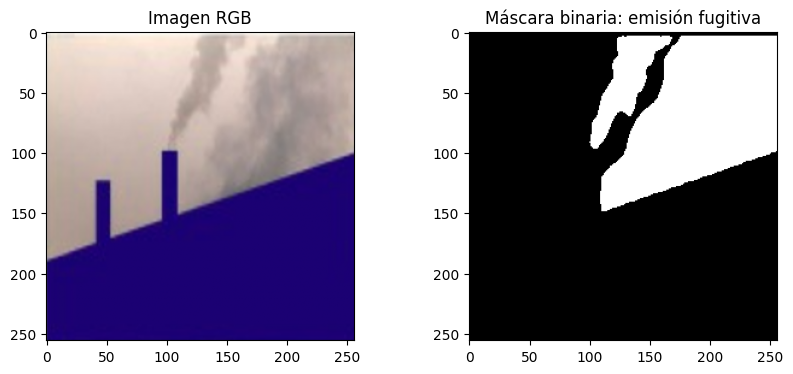

In [5]:
import matplotlib.pyplot as plt

# Visualizar una máscara binaria después del filtrado
sample_idx = 0
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(X[sample_idx])
plt.title("Imagen RGB")

plt.subplot(1, 2, 2)
plt.imshow(Y[sample_idx][:, :, 0], cmap='gray')
plt.title("Máscara binaria: emisión fugitiva")
plt.show()


**Paso 7: Evalacion **

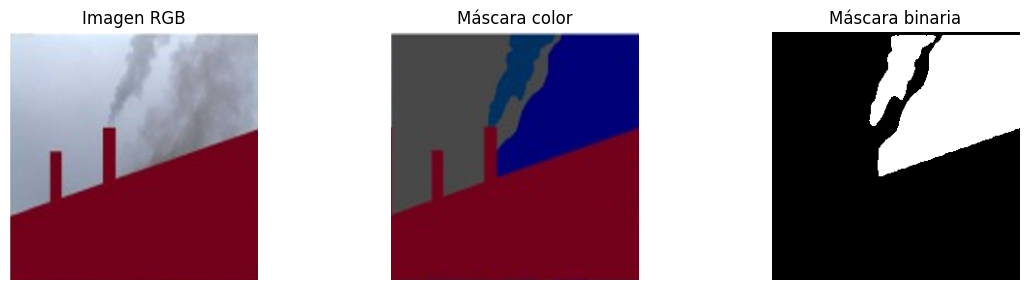

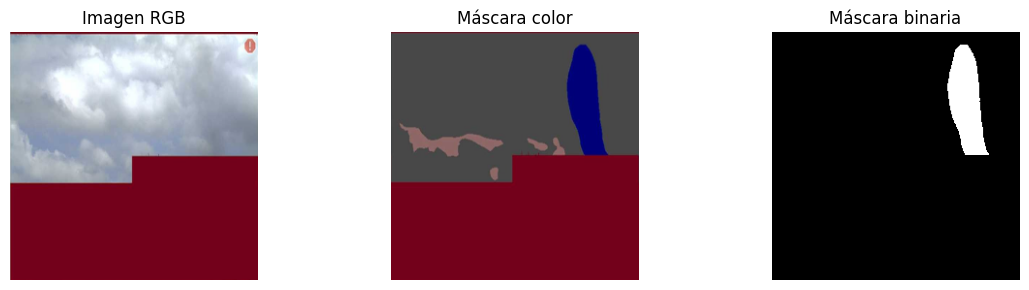

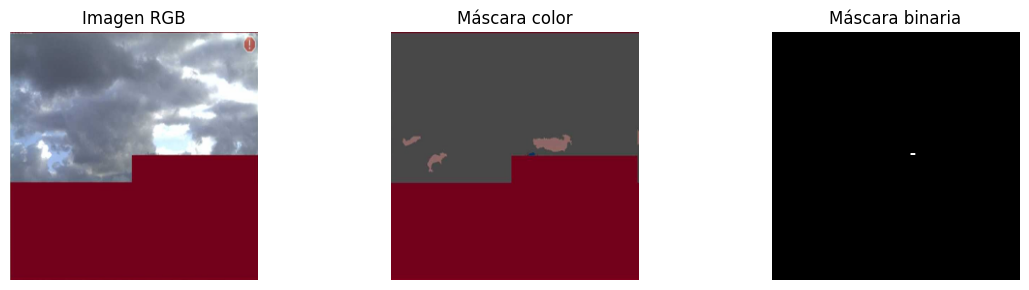

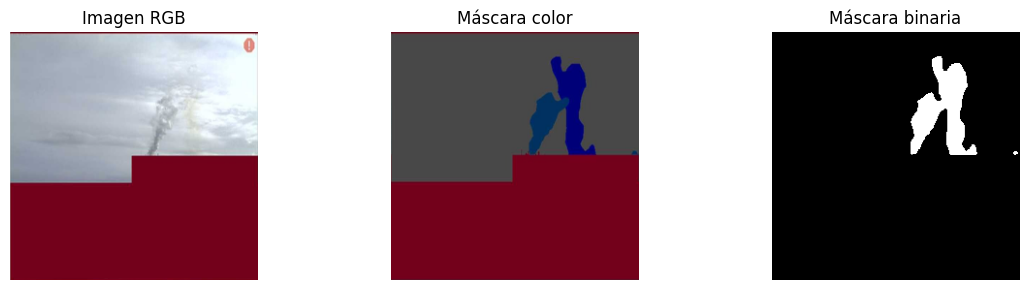

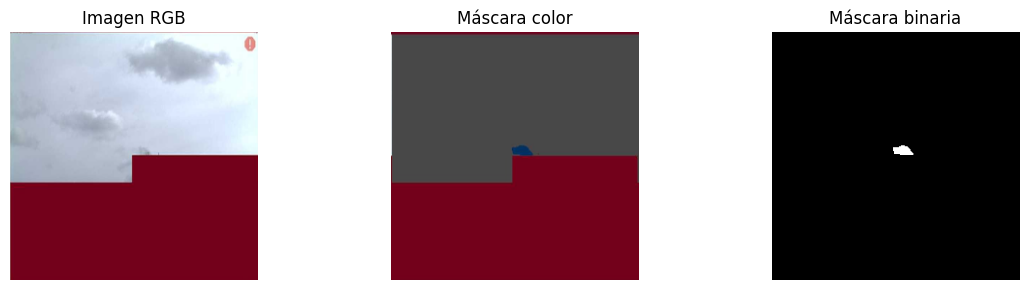

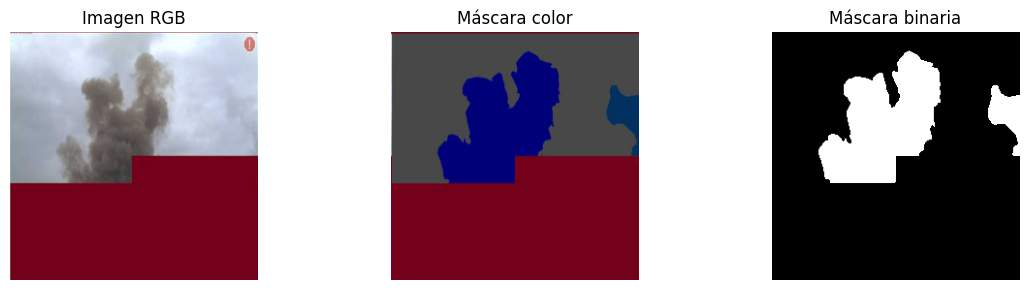

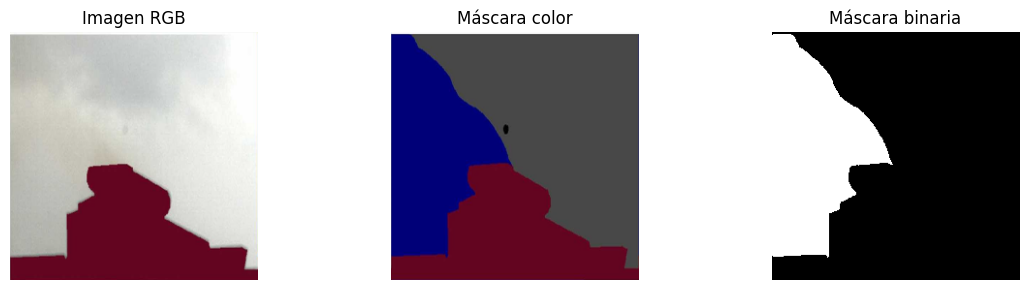

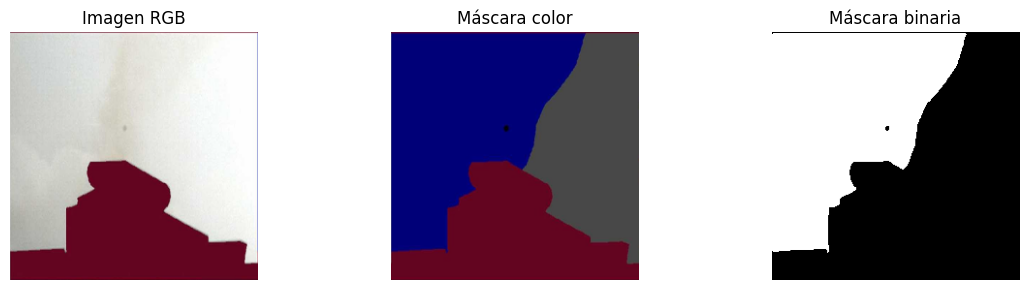

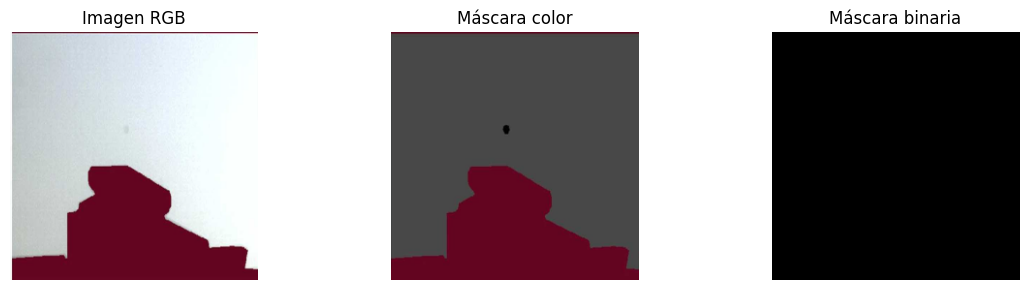

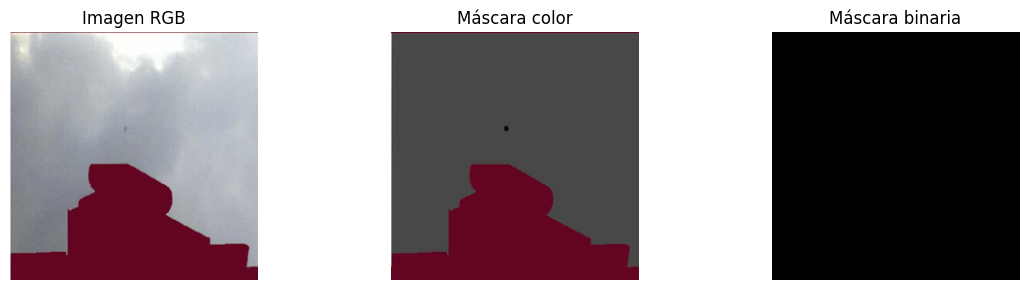

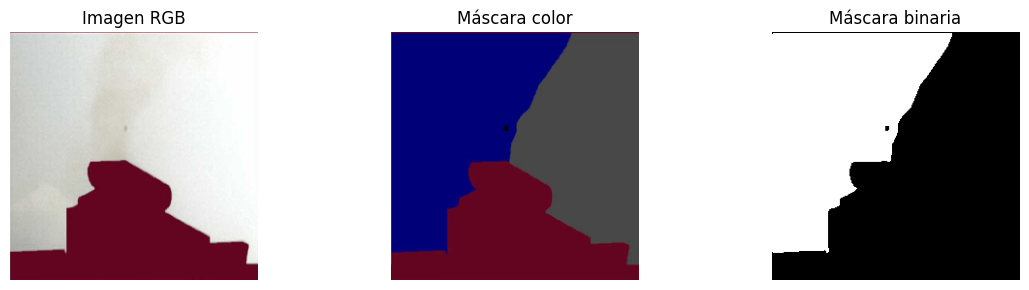

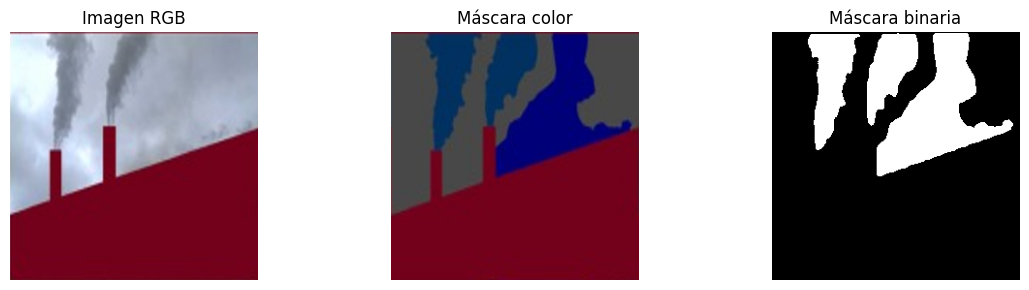

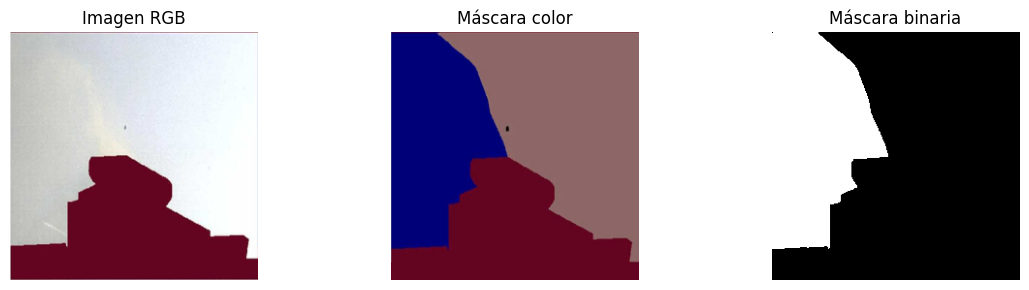

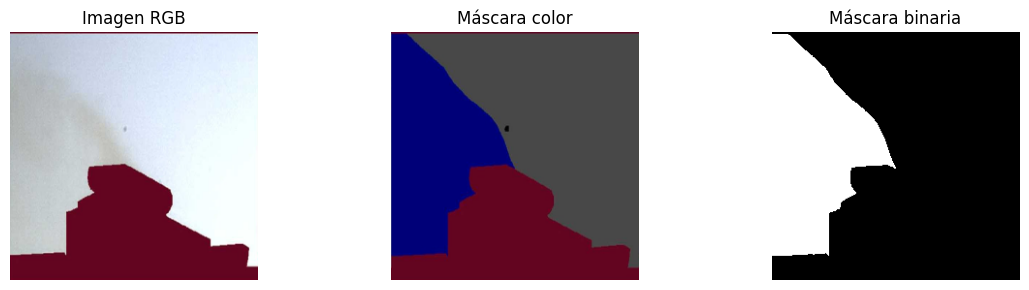

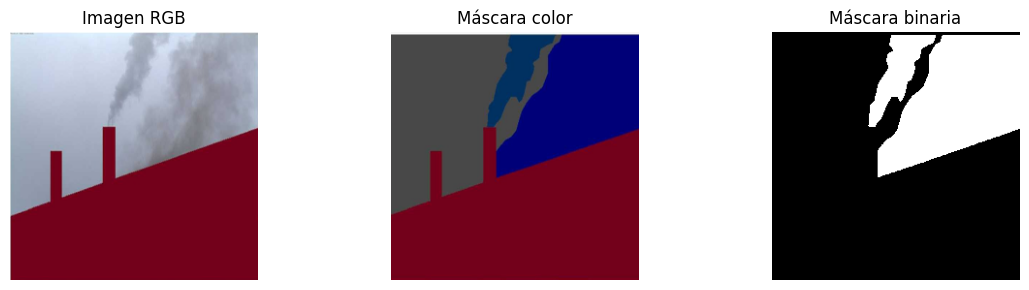

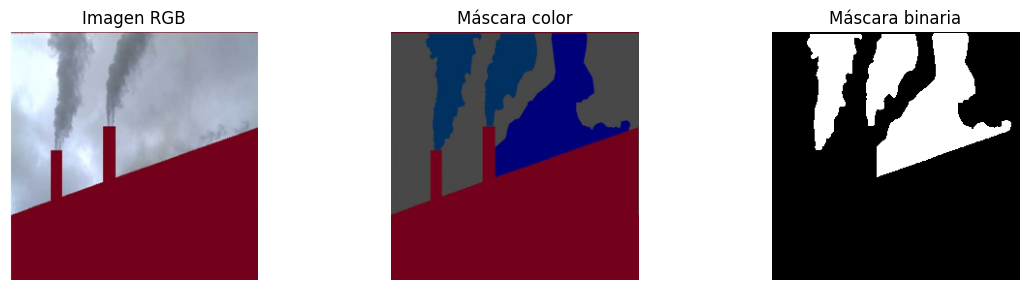

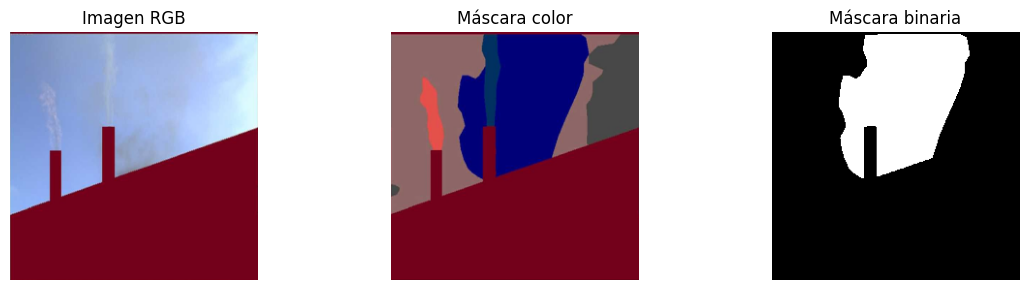

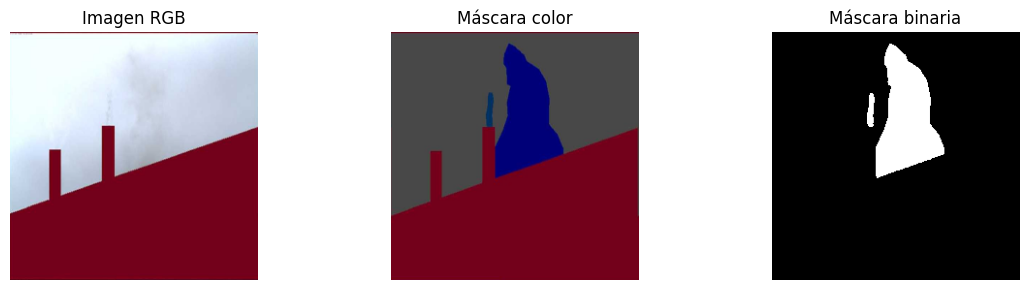

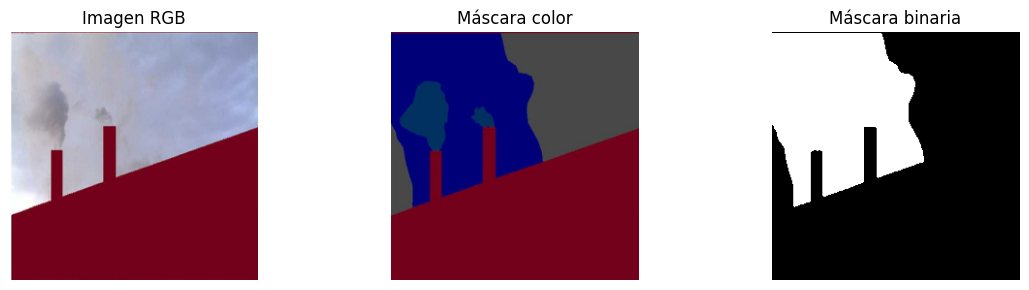

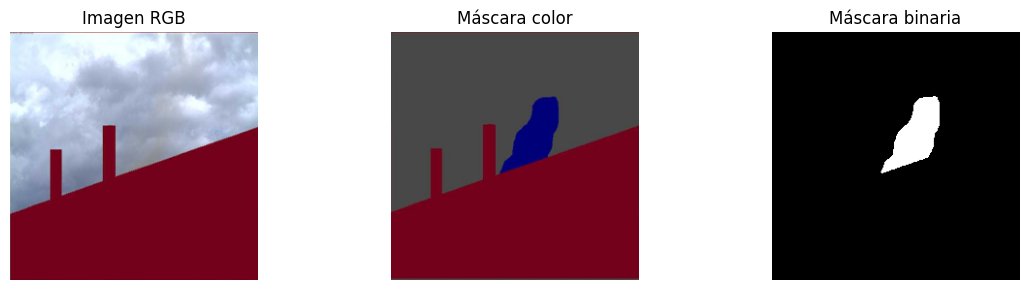

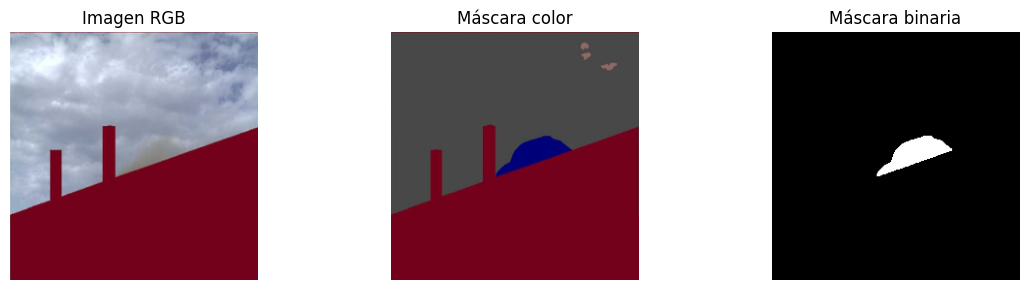

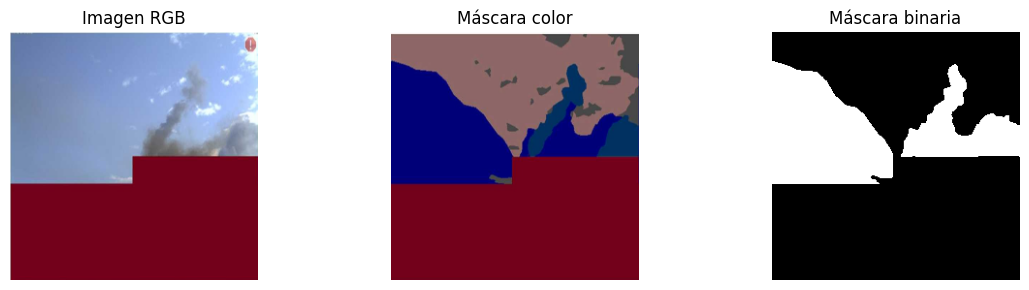

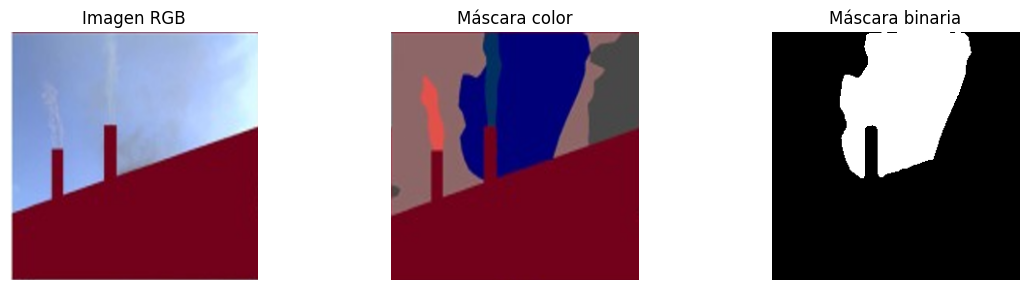

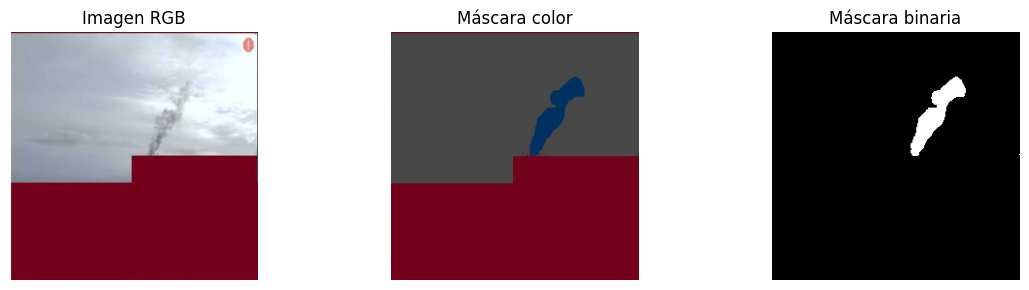

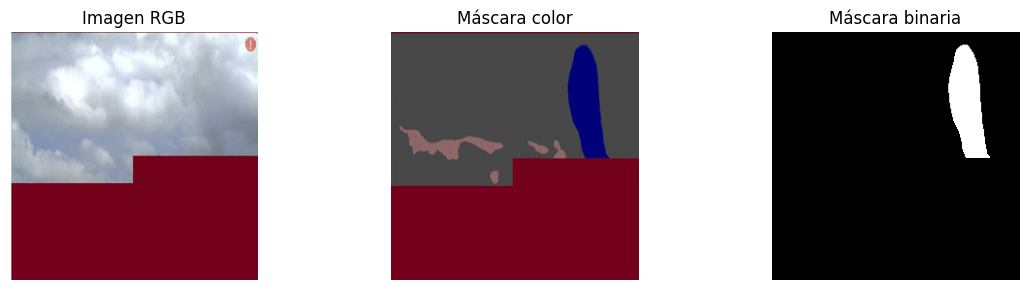

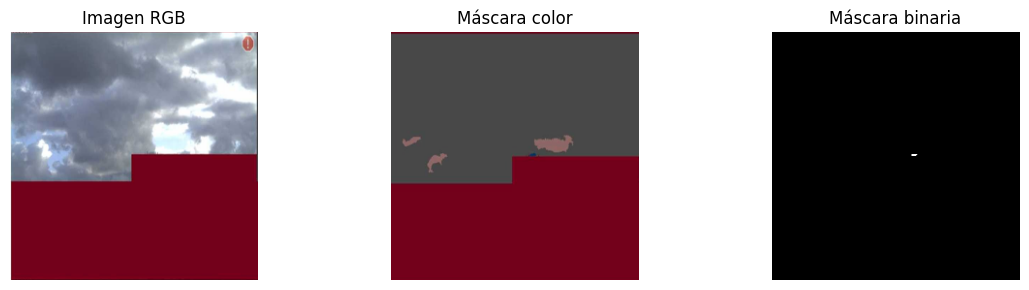

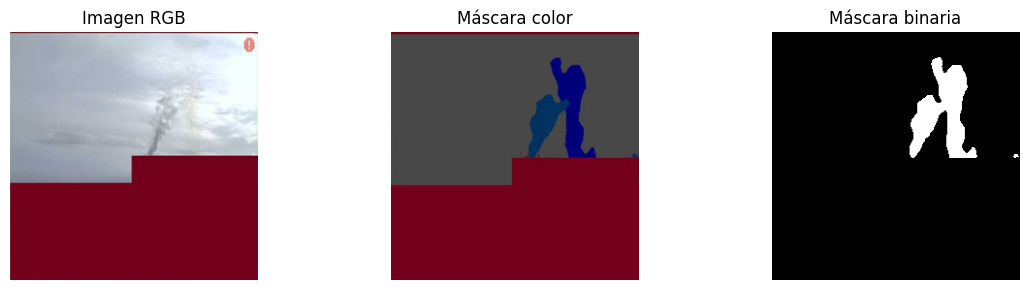

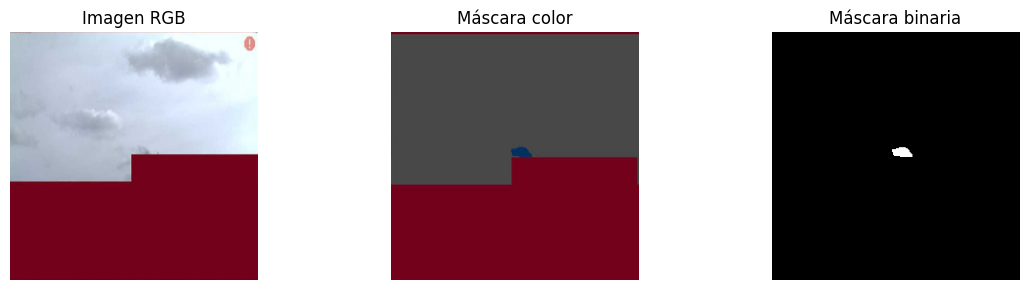

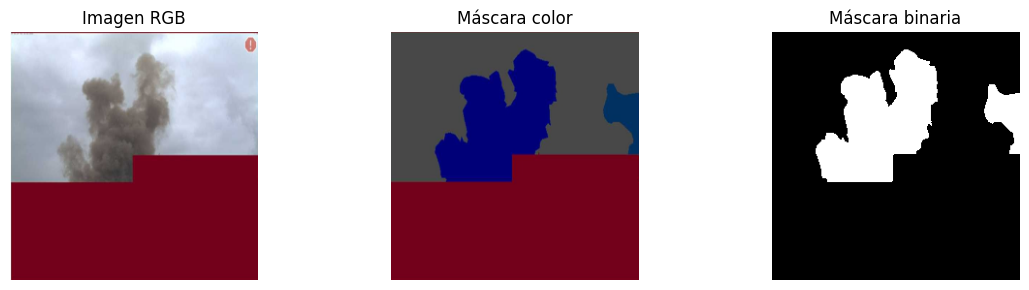

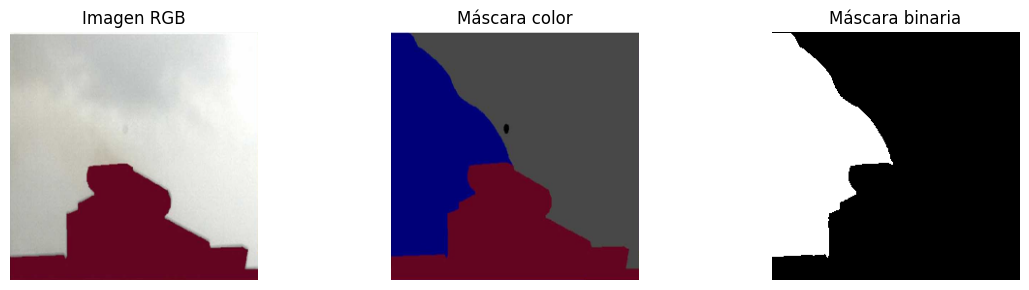

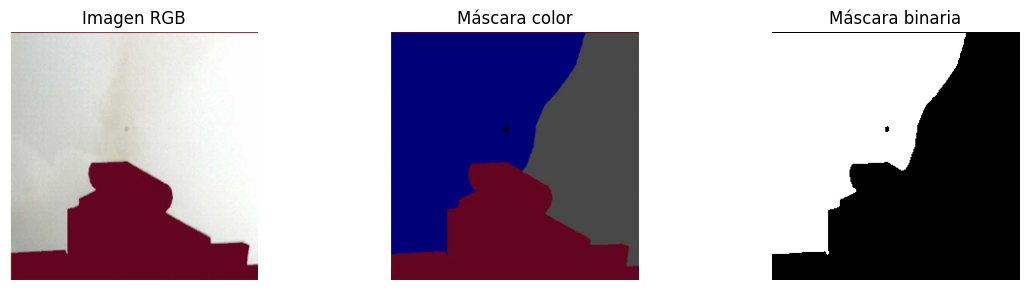

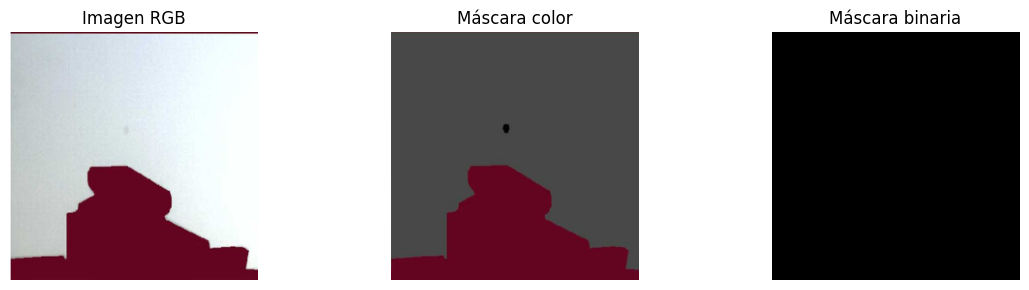

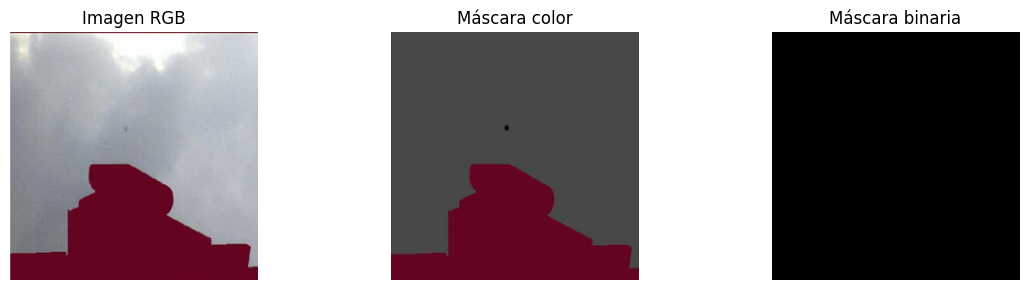

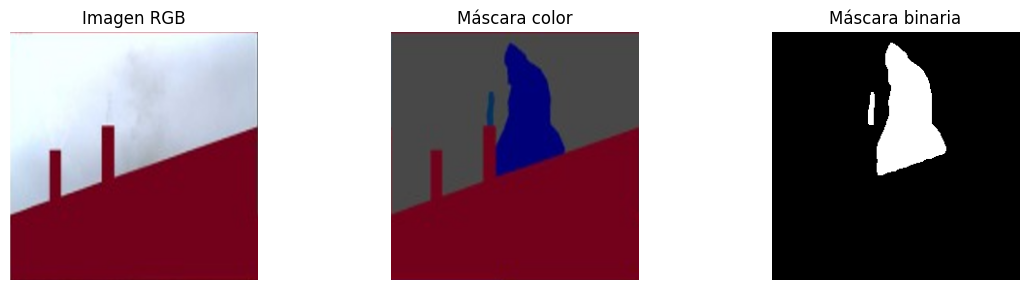

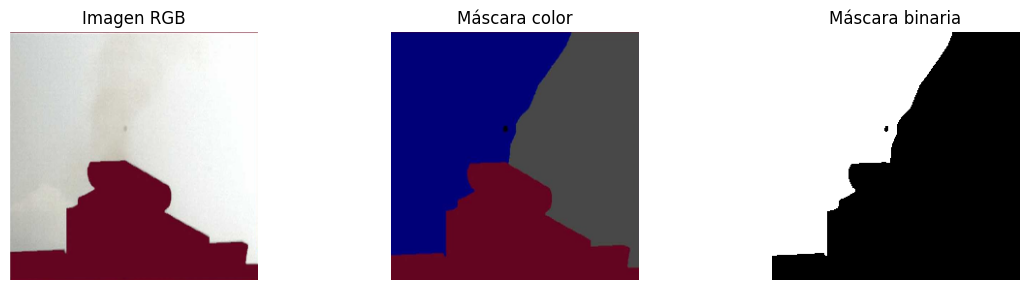

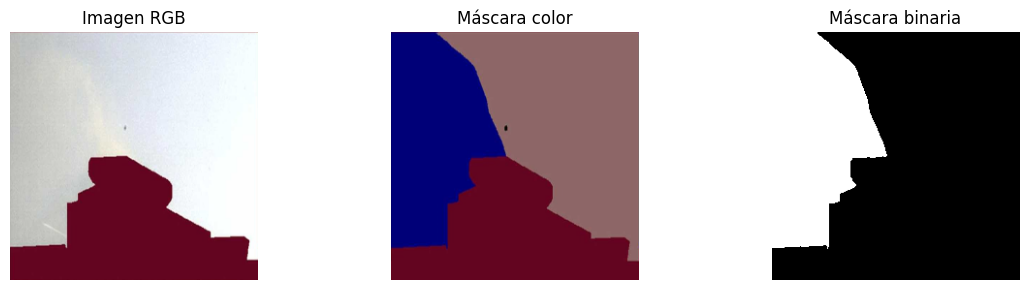

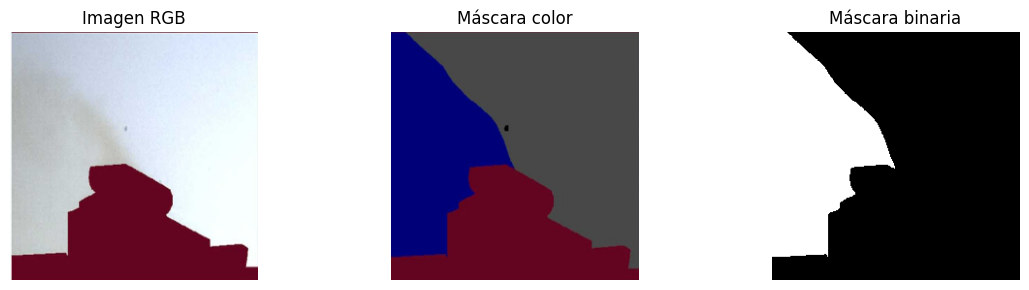

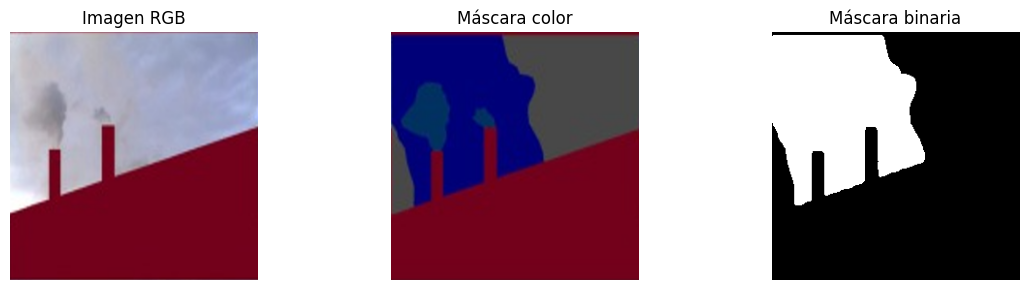

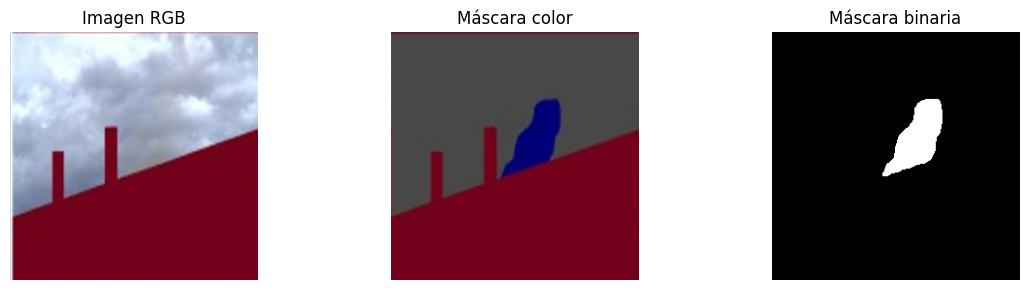

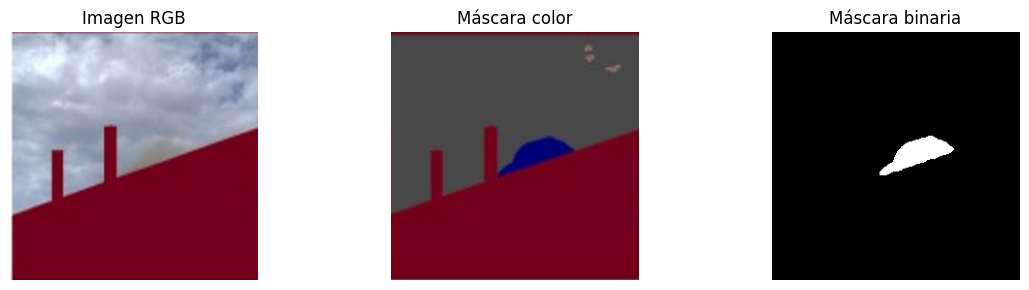

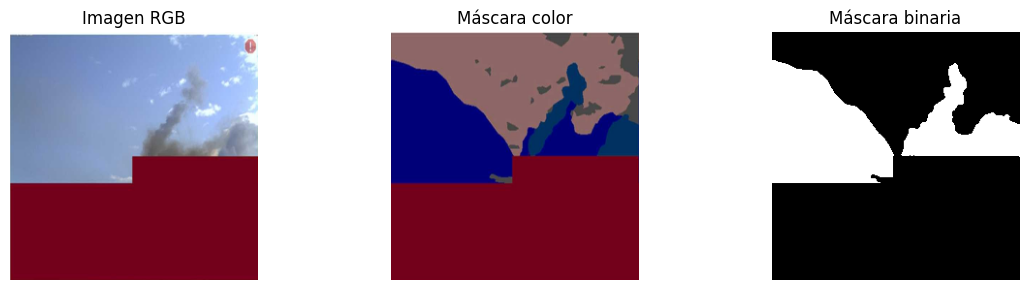

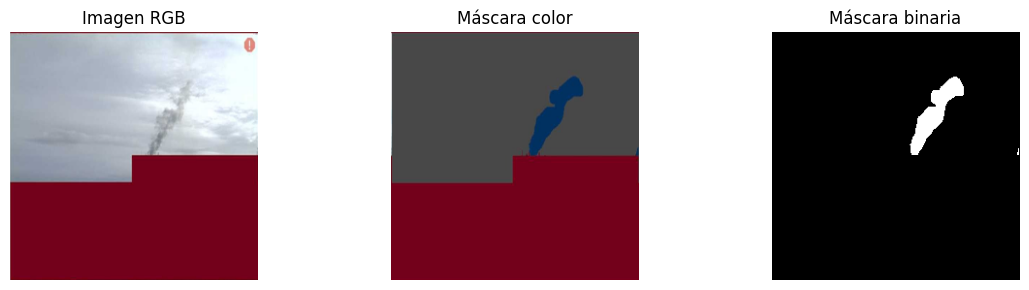

In [6]:
import matplotlib.pyplot as plt
import cv2
import os

# Mostrar todas las imágenes, máscaras en color y binarias
def mostrar_todas_las_imagenes(rgb_dir, mask_dir, X, Y, sample_size=42):
    rgb_files = sorted(os.listdir(rgb_dir))[:sample_size]
    mask_files = sorted(os.listdir(mask_dir))[:sample_size]

    for i in range(sample_size):
        rgb_path = os.path.join(rgb_dir, rgb_files[i])
        mask_path = os.path.join(mask_dir, mask_files[i])

        # Cargar imagen RGB original y máscara en color
        rgb_img = cv2.cvtColor(cv2.imread(rgb_path), cv2.COLOR_BGR2RGB)
        mask_color = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)

        # Asegurar que esté del mismo tamaño que la versión procesada
        rgb_img = cv2.resize(rgb_img, (256, 256))
        mask_color = cv2.resize(mask_color, (256, 256))
        bin_mask = Y[i][:,:,0]

        plt.figure(figsize=(12, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(rgb_img)
        plt.title("Imagen RGB")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask_color)
        plt.title("Máscara color")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(bin_mask, cmap='gray')
        plt.title("Máscara binaria")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

# Llamar la función
mostrar_todas_las_imagenes(rgb_dir, mask_dir, X, Y)

**Paso 8 Detectar gases en una imagen nueva**



In [7]:
model.save("modelo_fugas.h5")

In [8]:
from tensorflow.keras.models import load_model

# Cargar el modelo previamente entrenado
model = load_model("modelo_fugas.h5", compile=False)


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predecir_gas_en_imagen(model, ruta_imagen, size=(256, 256), umbral=0.5):
    img = cv2.imread(ruta_imagen)
    if img is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen: {ruta_imagen}")

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, size)
    entrada = np.expand_dims(img_resized / 255.0, axis=0)

    prediccion = model.predict(entrada)[0, :, :, 0]
    pred_binaria = (prediccion > umbral).astype(np.uint8)

    # Contar píxeles detectados como gas
    n_pixels_detectados = np.sum(pred_binaria)
    print(f"🟡 Píxeles detectados como gas: {n_pixels_detectados}")
    if n_pixels_detectados == 0:
        print("⚠️ No se detectó gas en esta imagen.")

    # Dibujar contornos sobre la imagen original
    contornos, _ = cv2.findContours(pred_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_contorno = img_resized.copy()
    cv2.drawContours(img_contorno, contornos, -1, (0, 255, 0), 2)  # contornos verdes

    # Mostrar resultados
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    ax[0].imshow(img_rgb)
    ax[0].set_title("Imagen Original")
    ax[1].imshow(prediccion, cmap='gray')
    ax[1].set_title("Predicción (Probabilidades)")
    ax[2].imshow(img_contorno)
    ax[2].set_title("Contornos de Gas Detectado")
    plt.tight_layout()
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🟡 Píxeles detectados como gas: 50269


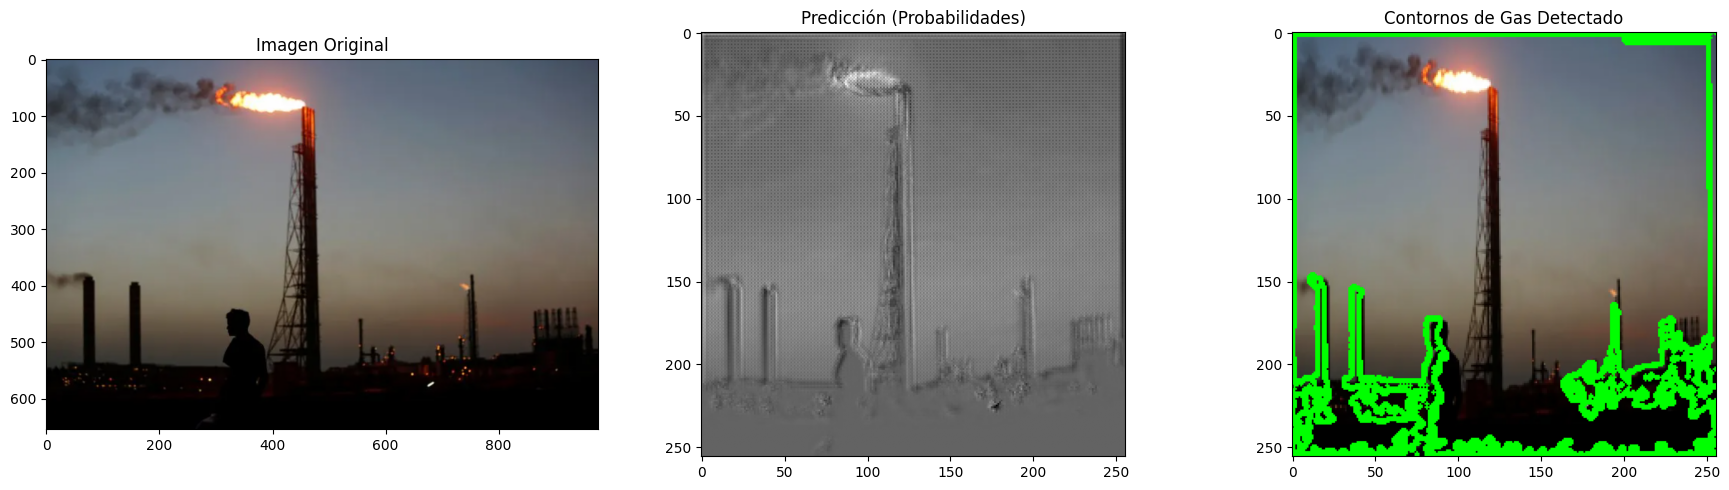

In [15]:
predecir_gas_en_imagen(model, "deteccion gas.png")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
🟡 Píxeles detectados como gas: 55285


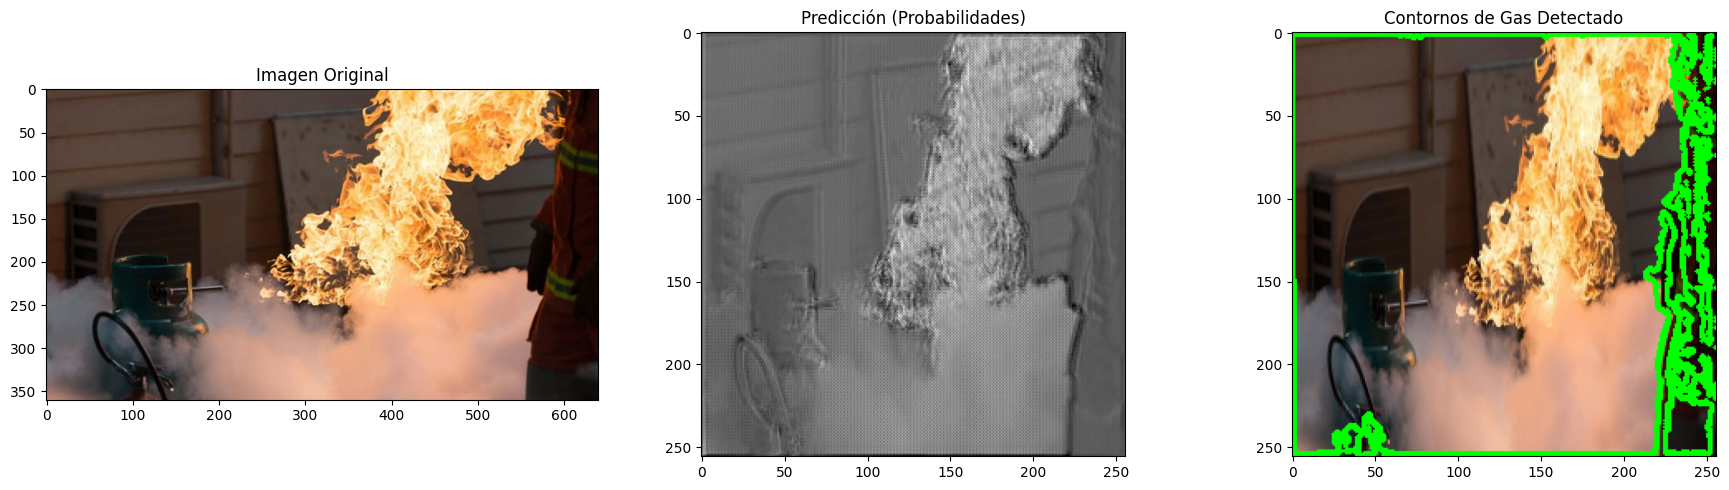

In [27]:
predecir_gas_en_imagen(model, "fuga-de-gas-negocio.jpg",umbral=0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🟡 Píxeles detectados como gas: 39118


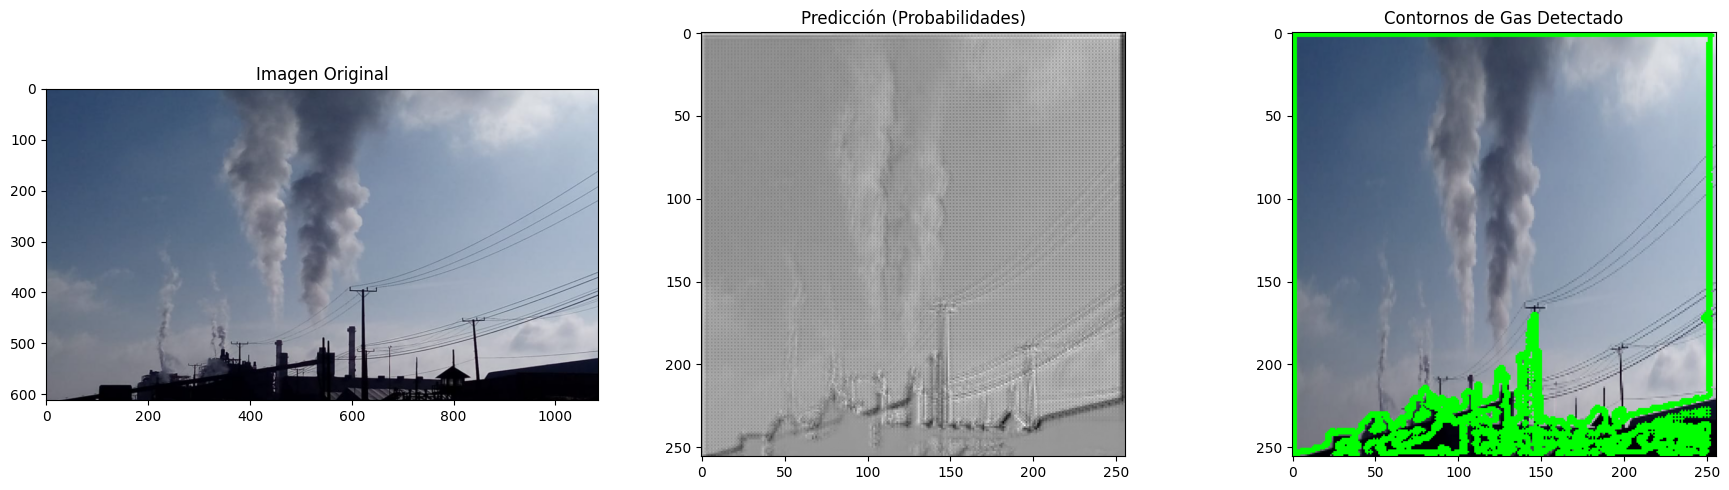

In [22]:
predecir_gas_en_imagen(model, "a.png",umbral=0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
🟡 Píxeles detectados como gas: 65094


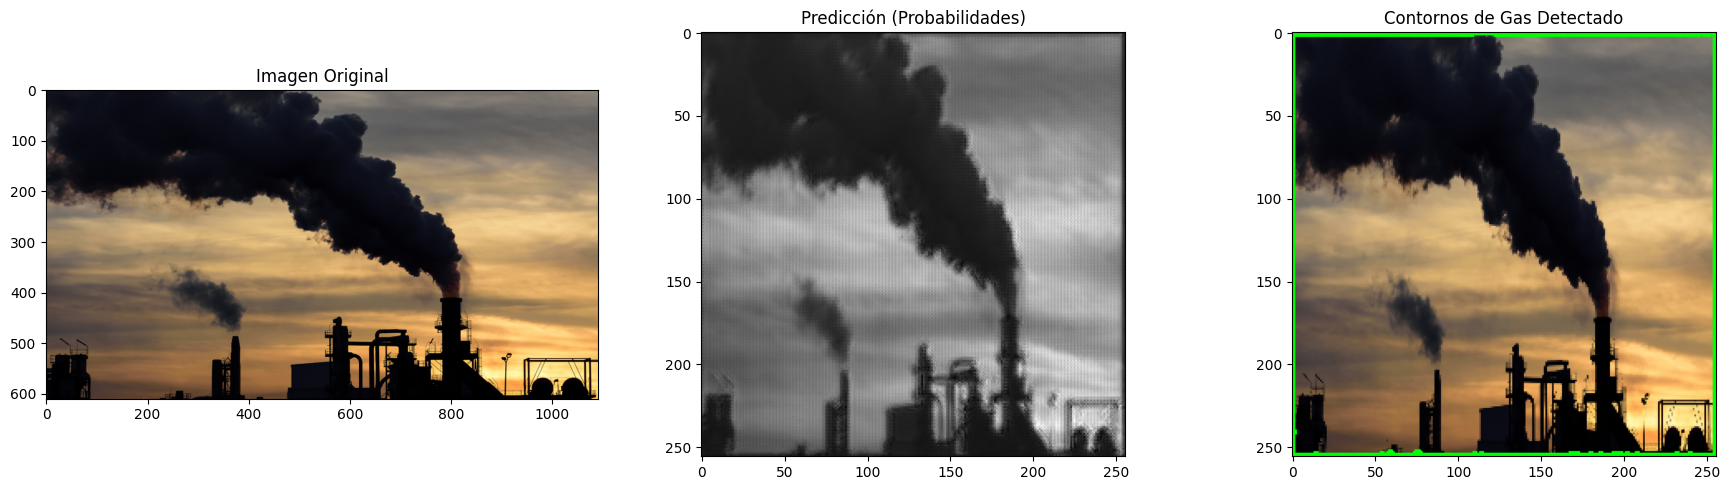

In [10]:
predecir_gas_en_imagen(model, "b.png",umbral=0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🟡 Píxeles detectados como gas: 0
⚠️ No se detectó gas en esta imagen.


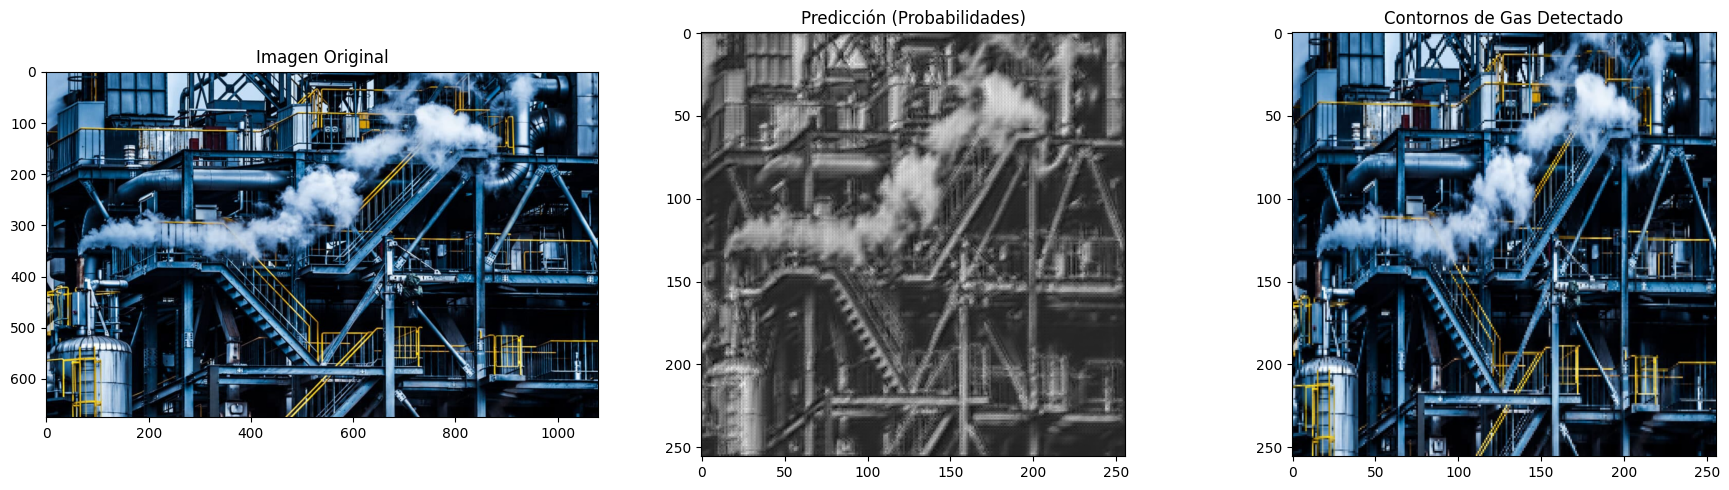

In [14]:
predecir_gas_en_imagen(model, "c.jpg",umbral=0.5)